In [4]:
!pip install numpy==1.21.5
!pip install opencv_python_headless==4.4.0.46
!pip install torch==1.10.2
!pip install matplotlib==3.3.4
!pip install torchvision==0.11.3

In [5]:
# from google.colab import drive
#
# drive.mount('/content/gdrive')

In [6]:
# ROOT_DIR = "gdrive/MyDrive/DataStunt/TransferLearning/"
ROOT_DIR = "../Input/"

In [7]:
#Importing Necessary files to read Images
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [8]:
## Printing random images from the dataset

Training_folder=ROOT_DIR+"Data/Training_data"
os.listdir(Training_folder)


['driving_license', 'others', 'social_security']

In [9]:
from torchvision.datasets import ImageFolder
ImageFolder(Training_folder)

Dataset ImageFolder
    Number of datapoints: 600
    Root location: ../Input/Data/Training_data

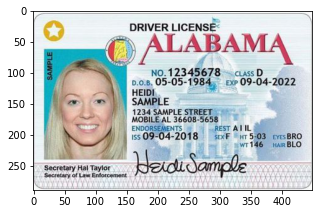

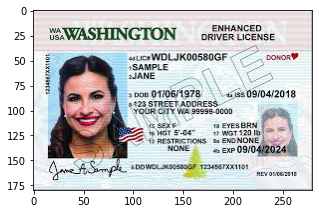

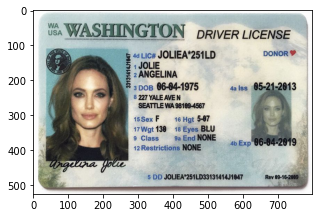

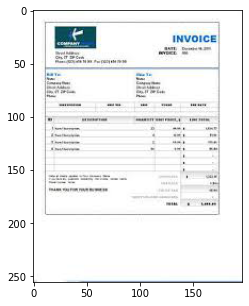

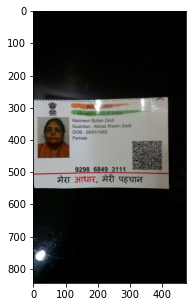

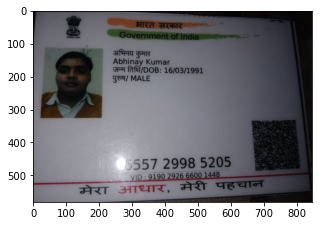

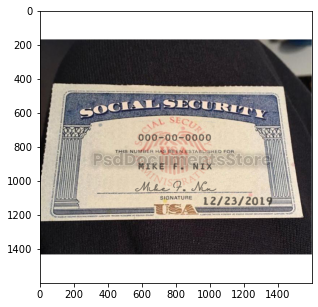

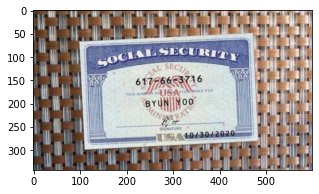

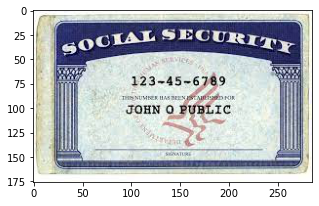

In [10]:

for path in os.listdir(Training_folder):
    for i in range(3):
        temp_path = Training_folder+"/"+path
        file = random.choice(os.listdir(temp_path))
        image_path= os.path.join(temp_path, file)
        img=mpimg.imread(image_path)
        plt.figure(figsize=(5,5))
        plt.imshow(img)


In [11]:
#Setting the Image dimension and source folder for loading the dataset
IMG_WIDTH=200
IMG_HEIGHT=200
Train_folder=ROOT_DIR+'Data/Training_data'
Test_folder=ROOT_DIR+'Data/Testing_Data'

In [12]:
#Creating the image data and the labels from the images
def create_dataset(Train_folder):
    img_data_array=[]
    class_name=[]
    classes = {'driving_license': [1,0,0], 'others': [0,1,0], 'social_security': [0,0,1]}
    for PATH in os.listdir(Train_folder):
        for file in os.listdir(os.path.join(Train_folder, PATH)):
            image_path= os.path.join(Train_folder, PATH,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float64')
            # image /= 255 
            if len(image.shape) == 3:
                img_data_array.append(np.array(image).reshape([3, 200, 200]))
                class_name.append(classes[PATH])
    return img_data_array, class_name

In [13]:
# extract the image array and class name for training data
Train_img_data, train_class_name = create_dataset(Train_folder)

# extract the image array and class name for testing data
Test_img_data, test_class_name =create_dataset(Test_folder)
len(Train_img_data)

597

In [14]:
train_class_name[0]

[1, 0, 0]

In [15]:
# Implementing a CNN in PyTorch
# importing necessary libraries
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable

In [16]:
# version of pytorch
print(torch.__version__)

1.10.2+cpu


In [17]:
torch_dataset_train = Data.TensorDataset(Tensor(np.array(Train_img_data)), Tensor(np.array(train_class_name)))
torch_dataset_test = Data.TensorDataset(Tensor(np.array(Test_img_data)), Tensor(np.array(test_class_name)))

In [18]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(torch_dataset_train, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=8, shuffle=True)

In [19]:
# shape of training data
dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([8, 3, 200, 200])

In [20]:
# filepath = ROOT_DIR+"model.pt"
# torch.save(model.state_dict(), filepath)

In [21]:
# model_trained = CNNNet()
# model_trained.load_state_dict(torch.load(filepath))

In [22]:
from torchvision import datasets, transforms, models

In [23]:
model_resnet = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\hemje/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


In [24]:
for param in model_resnet.parameters():
    param.requires_grad = False
    
model_resnet.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 3)
                                 )

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)
device=('cuda' if torch.cuda.is_available() else 'cpu')
model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
#train this model for 10 epochs
for i in range(10):
    
    running_loss = 0
    model_resnet.train() # indicator for training phase
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.to(device)
          labels = labels.to(device)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model_resnet(images)
        
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 0.9792499605814616
Epoch 2 - Training loss: 0.6097717207670211
Epoch 3 - Training loss: 0.5532698592543602
Epoch 4 - Training loss: 0.5135609329740206
Epoch 5 - Training loss: 0.41204423169294996
Epoch 6 - Training loss: 0.3925838667154312
Epoch 7 - Training loss: 0.3929649819930395
Epoch 8 - Training loss: 0.43194765875736874
Epoch 9 - Training loss: 0.37125632012883825
Epoch 10 - Training loss: 0.37543921381235124


In [27]:

# [.2, .5, .3]
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model_resnet(x_batch)
        
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

In [28]:
y_true_list_max = [m.argmax() for m in y_true_list]

In [29]:
correct_count, all_count = 0, 0
for i in range(len(y_pred_list)):
    if(y_pred_list[i] == y_true_list_max[i]):
      correct_count += 1
    all_count += 1
print("\nModel Accuracy =", (correct_count/all_count))


Model Accuracy = 0.6711409395973155
